In [2]:
#Import Packages
import numpy as np
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import heapq
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import netrd as net
from itertools import combinations as cm


In [3]:
#Cancer Networks

#read in sample sheet
ss = pl.read_csv('Ovary/sample_sheet.tsv', separator = '\t')
#print(ss.head())

# Get the list of column names
column_names = ss.columns

#read in dictionary
raw_dict = pl.read_excel('Ovary/dictionary_ids.xlsx', read_options = {"header_row": 1})
print(raw_dict.head())

shape: (5, 2)
┌─────────────────┬──────────────────┐
│ Model id        ┆ TCGA id          │
│ ---             ┆ ---              │
│ str             ┆ str              │
╞═════════════════╪══════════════════╡
│ MODEL1707110006 ┆ TCGA_04_1332_01A │
│ MODEL1707110007 ┆ TCGA_04_1338_01A │
│ MODEL1707110008 ┆ TCGA_04_1341_01A │
│ MODEL1707110009 ┆ TCGA_04_1343_01A │
│ MODEL1707110010 ┆ TCGA_04_1347_01A │
└─────────────────┴──────────────────┘


In [4]:
avg_k_in = []
avg_k_out = []

#Create list of graphs (Tissue specific )
list_graphs = []
for i in range (ss.height):
    filepath = (f"Ovary/Metabolites-based/Metabolites-based_tissue/meanSum_{ss['Sample.ID'][i]}.graphml")
    #print(filepath)

    in_deg = []
    out_deg = []

    g = nx.read_graphml(filepath)
    
    for n, d in g.in_degree():
        in_deg.append(d)
    for n, d in g.out_degree():
        out_deg.append(d)
    
    avg_k_in.append(np.mean(in_deg))
    avg_k_out.append(np.mean(out_deg))

    list_graphs.append(g)
    #print(len(list_graphs))

In [4]:
per_node_in = {}
per_node_out = {}

#Calculate average in and out degree for every node across all graphs
for g in list_graphs:
    for i, n in enumerate(g.nodes()):
        if n not in per_node_in or n not in per_node_out:
            per_node_in[n] = 0
            per_node_out[n] = 0
        per_node_in[n] += g.in_degree(n)
        per_node_out[n] += g.out_degree(n)
    for n in g.nodes():
        per_node_in[n] /= len(list_graphs)
        per_node_out[n] /= len(list_graphs)

test_in = []
test_out = []

#for n, d in enumerate(list_graphs[0].nodes()):
    #test_in.append(list_graphs[0].in_degree(d))
    #test_out.append(list_graphs[0].out_degree(d))

#np.save('test_in.npy', test_in)
#np.save('test_out.npy', test_out)

#Save per_node_in and per_node_out in .npy files
#np.save('per_node_in1.npy', np.array(list(per_node_in.values())))
#np.save('per_node_out1.npy', np.array(list(per_node_out.values())))

In [5]:
#Single graph test statistics
filepath = (f"Ovary/Metabolites-based/Metabolites-based_tissue/meanSum_TCGA-04-1331-01A.graphml")
G = nx.read_graphml(filepath)

pos = nx.forceatlas2_layout(G, max_iter = 100, scaling_ratio = 0.5, gravity = 0.5, dissuade_hubs=True)
#pos = nx.spring_layout(G, k=1000, iterations=50, method = 'energy', gravity = 0.5, scale = 20)

#nx.draw_networkx_nodes(G, pos, node_size=1)


weights_dict = nx.get_edge_attributes(G, 'weight')
edge_weights = [weights_dict[edge] for edge in G.edges()]

scaled_weights = [w * 0.1 for w in edge_weights]

plt.figure(figsize=(20, 16))
nx.draw_networkx_edges(G, pos, width=scaled_weights)
plt.show()

degrees = [deg for _, deg in G.in_degree()] # For any graph G

vals, freq = np.unique(degrees, return_counts=True)

plt.scatter(vals, freq, marker="o")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.title("In-Degree Distribution (Ovarian Cancer Tissue)")
plt.show()

degrees = [deg for _, deg in G.out_degree()] # For any graph G

vals, freq = np.unique(degrees, return_counts=True)

plt.scatter(vals, freq, marker="o")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.title("Out-Degree Distribution (Ovarian Cancer Tissue)")
plt.show()

In [7]:
#Basic Network Stats

#Nodes and Edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

print(f"Average in-degree: {np.mean([deg for _, deg in G.in_degree()])}")
print(f"Average out-degree: {np.mean([deg for _, deg in G.out_degree()])}")

#Strongly connected
print(nx.is_strongly_connected(G))

#Node names
node_names = nx.get_node_attributes(G, 'name')
print(node_names)

Number of nodes: 3827
Number of edges: 8533
Average in-degree: 2.2296838254507447
Average out-degree: 2.2296838254507447
False
{'n0': 'm01570s', 'n1': 'm02956s', 'n2': 'm00234s', 'n3': 'm00503c', 'n4': 'm03147s', 'n5': 'm02959s', 'n6': 'm00241s', 'n7': 'm00510c', 'n8': 'm02048s', 'n9': 'm02353s', 'n10': 'm01451s', 'n11': 'm01268n', 'n12': 'm01268c', 'n13': 'm00240c', 'n14': 'm00511c', 'n15': 'm00560c', 'n16': 'm00656c', 'n17': 'm01450c', 'n18': 'm01451c', 'n19': 'm01813c', 'n20': 'm02629c', 'n21': 'm02684c', 'n22': 'm02685c', 'n23': 'm02750c', 'n24': 'm02808c', 'n25': 'm02908c', 'n26': 'm02958c', 'n27': 'm02392c', 'n28': 'm02774c', 'n29': 'm01410s', 'n30': 'm01412c', 'n31': 'm01412m', 'n32': 'm02348c', 'n33': 'm02635m', 'n34': 'm02348m', 'n35': 'm02409c', 'n36': 'm02409m', 'n37': 'm03134s', 'n38': 'm02694c', 'n39': 'm02120s', 'n40': 'm02122c', 'n41': 'm02108s', 'n42': 'm02107c', 'n43': 'm02642s', 'n44': 'm02644c', 'n45': 'm02614s', 'n46': 'm02616c', 'n47': 'm01648s', 'n48': 'm01650c', 

In [8]:
#Centralities

#Calculate average centrality measures across all graphs

#Initialize dictionaries to hold gloobal centrality measures
global_harmonic_dict = {}
global_weighted_eigen_dict = {}
global_weighted_betweenness_dict = {}
global_pagerank_dict = {}
global_weighted_degree_dict = {}


#Assign an empty list to each node in the graph to hold centrality measures across all graphs
for name in node_names.values():
    global_harmonic_dict[name] = []
    global_weighted_eigen_dict[name] = []
    global_weighted_betweenness_dict[name] = []
    global_pagerank_dict[name] = []
    global_weighted_degree_dict[name] = []

#Get centrality measures for each node in each graph and append to global dictionaries
for g in list_graphs:
    for name in node_names.values():

        harmonic = nx.harmonic_centrality(g)
        global_harmonic_dict[name].append(harmonic.get(name, 0))

        weighted_eigen = nx.eigenvector_centrality(G, max_iter=500, weight='weight')
        global_weighted_eigen_dict[name].append(weighted_eigen.get(name, 0))

        weighted_betweenness = nx.betweenness_centrality(G, weight='weight')
        global_weighted_betweenness_dict[name].append(weighted_betweenness.get(name, 0))

        pagerank = nx.pagerank(G, weight='weight')
        global_pagerank_dict[name].append(pagerank.get(name, 0))

        weighted_degree = {n: d / (len(G)-1) for n, d in G.degree(weight='weight')}
        global_weighted_degree_dict[name].append(weighted_degree.get(name,0))

#Calculate average centrality measures for each node across all graphs
avg_harmonic_dict = {name: np.mean(scores) for name, scores in global_harmonic_dict.items()}
avg_weighted_eigen_dict = {name: np.mean(scores) for name, scores in global_weighted_eigen_dict.items()}
avg_weighted_betweenness_dict = {name: np.mean(scores) for name, scores in global_weighted_betweenness_dict.items()}
avg_pagerank_dict = {name: np.mean(scores) for name, scores in global_pagerank_dict.items()}
avg_weighted_degree_dict = {name: np.mean(scores) for name, scores in global_weighted_degree_dict.items()}


harmonic = nx.harmonic_centrality(G)
weighted_eigen = nx.eigenvector_centrality(G, max_iter=500, weight='weight')
weighted_betweenness = nx.betweenness_centrality(G, weight='weight')
pagerank = nx.pagerank(G, weight='weight')
weighted_degree = {n: d / (len(G)-1) for n, d in G.degree(weight='weight')}

def assign_names(node_dict, name_dict) -> list: #Assign metabolite names to centrality scores and sort by score
    new_dict = {}
    for key in node_dict.keys():
        if key in name_dict:
            new_dict[name_dict[key]] = node_dict[key]
    new_list = (sorted(new_dict.items(), key=lambda item:item[1], reverse=True))
    return new_list

#Run assign names function for all centrality measures
sorted_degree = assign_names(weighted_degree, node_names)
sorted_harmonic = assign_names(harmonic, node_names)
sorted_eigen = assign_names(weighted_eigen, node_names)
sorted_between = assign_names(weighted_betweenness, node_names)
sorted_pagerank = assign_names(pagerank, node_names)

#Print results
print(f"Degree Centrality: {sorted_degree}")
print(f"Harmonic Centrality: {sorted_harmonic}")
print(f"Weighted Eigenvector Centrality: {sorted_eigen}")
print(f"Weighted Betweenness Centrality: {sorted_between}")
print(f"Weighted PageRank: {sorted_pagerank}")

#Run assign names function for all averaged centrality measures
sorted_degree = assign_names(weighted_degree, node_names)
sorted_harmonic = assign_names(harmonic, node_names)
sorted_eigen = assign_names(weighted_eigen, node_names)
sorted_between = assign_names(weighted_betweenness, node_names)
sorted_pagerank = assign_names(pagerank, node_names)

#Print results
print(f"Average Degree Centrality: {sorted(avg_weighted_degree_dict.items(), key=lambda item:item[1], reverse=True)}")
print(f"Average Harmonic Centrality: {sorted(avg_harmonic_dict.items(), key=lambda item:item[1], reverse=True)}")
print(f"Average Weighted Eigenvector Centrality: {sorted(avg_weighted_eigen_dict.items(), key=lambda item:item[1], reverse=True)}")
print(f"Average Weighted Betweenness Centrality: {sorted(avg_weighted_betweenness_dict.items(), key=lambda item:item[1], reverse=True)}")
print(f"Average Weighted PageRank: {sorted(avg_pagerank_dict.items(), key=lambda item:item[1], reverse=True)}")


KeyboardInterrupt: 

In [5]:
#Different method for calculating average centrality measures for all nodes
#Create an average adjacency matrix, then create graph from matrix and run centrality measures

#Create list of adjacency matrices
adj_list = []

matcount = 0
for g in list_graphs:
    adj = nx.adjacency_matrix(g, weight = 'weight')
    adj_list.append(adj)
    #print(f"Adjacency Matrix {matcount} added")
    matcount += 1

#Average the list of adjacency matrices
avgcount = 0
avg_adj = np.zeros(adj_list[0].shape)
for A in adj_list:
    avg_adj += A
    #print(f"Adjacency Matrix {avgcount} added to average")
    avgcount += 1

avg_adj /= len(adj_list)

#Create graph from average adjacency matrix
avg_G = nx.from_numpy_array(avg_adj, create_using = nx.DiGraph)




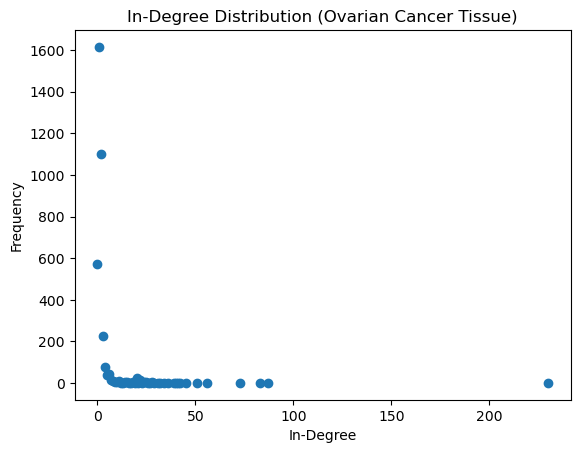

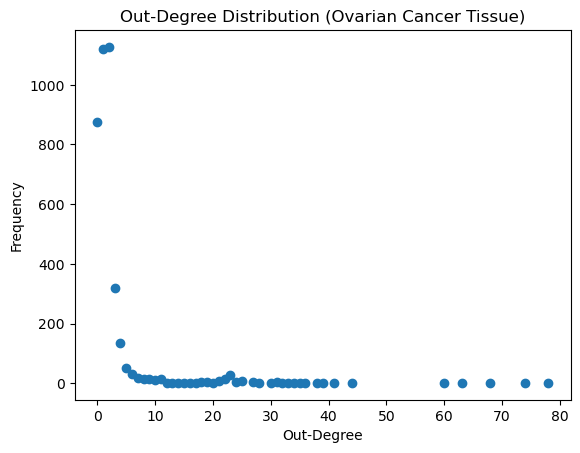

In [6]:
#Visualize Average Graph

pos = nx.forceatlas2_layout(avg_G, max_iter = 100, scaling_ratio = 0.5, gravity = 0.5, dissuade_hubs=True)
#pos = nx.spring_layout(G, k=1000, iterations=50, method = 'energy', gravity = 0.5, scale = 20)

#nx.draw_networkx_nodes(G, pos, node_size=1)


weights_dict = nx.get_edge_attributes(avg_G, 'weight')
edge_weights = [weights_dict[edge] for edge in avg_G.edges()]

scaled_weights = [w * 0.1 for w in edge_weights]

plt.figure(figsize=(20, 16))
nx.draw_networkx_edges(avg_G, pos, width=scaled_weights)
plt.show()

degrees = [deg for _, deg in avg_G.in_degree()] # For any graph G

vals, freq = np.unique(degrees, return_counts=True)

plt.scatter(vals, freq, marker="o")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.title("In-Degree Distribution (Ovarian Cancer Tissue)")
plt.show()

degrees = [deg for _, deg in avg_G.out_degree()] # For any graph G

vals, freq = np.unique(degrees, return_counts=True)

plt.scatter(vals, freq, marker="o")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.title("Out-Degree Distribution (Ovarian Cancer Tissue)")
plt.show()

In [ ]:
#Calculate centrality data for average graph (Copied from other cells)

harmonic = nx.harmonic_centrality(avg_G)
weighted_eigen = nx.eigenvector_centrality(avg_G, max_iter=500, weight='weight')
weighted_betweenness = nx.betweenness_centrality(avg_G, weight='weight')
pagerank = nx.pagerank(avg_G, weight='weight')
weighted_degree = {n: d / (len(avg_G)-1) for n, d in avg_G.degree(weight='weight')}

def assign_names(node_dict, name_dict) -> list: #Assign metabolite names to centrality scores and sort by score
    new_dict = {}
    for key in node_dict.keys():
        if key in name_dict:
            new_dict[name_dict[key]] = node_dict[key]
    new_list = (sorted(new_dict.items(), key=lambda item:item[1], reverse=True))
    return new_list

#Run assign names function for all centrality measures
sorted_degree = assign_names(weighted_degree, node_names)
sorted_harmonic = assign_names(harmonic, node_names)
sorted_eigen = assign_names(weighted_eigen, node_names)
sorted_between = assign_names(weighted_betweenness, node_names)
sorted_pagerank = assign_names(pagerank, node_names)

#Print results
print(f"Degree Centrality: {sorted_degree}")
print(f"Harmonic Centrality: {sorted_harmonic}")
print(f"Weighted Eigenvector Centrality: {sorted_eigen}")
print(f"Weighted Betweenness Centrality: {sorted_between}")
print(f"Weighted PageRank: {sorted_pagerank}")

# Visualize Centralities as columns (top N per column) and build numeric DataFrame
top_n = 25
full_lists = [sorted_degree, sorted_harmonic, sorted_eigen, sorted_between, sorted_pagerank]
headers = ["Degree Centrality", "Harmonic Centrality", "Eigenvector Centrality", "Betweenness Centrality", "PageRank Centrality"]

# Prepare formatted columns (each column is top_n entries, padded if necessary)
formatted_columns = []
for lst in full_lists:
    col = []
    for i in range(top_n):
        if i < len(lst):
            name, val = lst[i]
            col.append(f"{name}\n({val:.4f})")
        else:
            col.append("")
    formatted_columns.append(col)

# Transpose columns to rows for table display: each row is the i-th ranked entry across measures
data = [list(row) for row in zip(*formatted_columns)]

fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')
ax.axis('tight')

# Draw table; set column widths so it fits better
col_width = 1.0 / len(headers)
cent_table = ax.table(cellText=data, colLabels=headers, loc='center', colWidths=[col_width] * len(headers))
cent_table.auto_set_font_size(False)
cent_table.set_fontsize(9)
cent_table.scale(1, 1.5)

plt.tight_layout()
plt.show()

# Build a numeric centrality DataFrame (nodes x measures). Missing values filled with 0.
centrality_df = pd.DataFrame({
    headers[i]: dict(full_lists[i])
    for i in range(len(headers))
})
centrality_df = centrality_df.fillna(0)

print(centrality_df.head())

Degree Centrality: []
Harmonic Centrality: []
Weighted Eigenvector Centrality: []
Weighted Betweenness Centrality: []
Weighted PageRank: []


IndexError: list index out of range

In [ ]:
#Visualize Centralities (table-only - re-usable cell)
# This cell assumes `sorted_degree`, `sorted_harmonic`, `sorted_eigen`, `sorted_between`, `sorted_pagerank` are already defined.

try:
    full_lists = [sorted_degree, sorted_harmonic, sorted_eigen, sorted_between, sorted_pagerank]
except NameError:
    raise RuntimeError('Run the centrality-calculation cell before running this visualization cell')

top_n = 25
headers = ["Degree Centrality", "Harmonic Centrality", "Eigenvector Centrality", "Betweenness Centrality", "PageRank Centrality"]

formatted_columns = []
for lst in full_lists:
    col = []
    for i in range(top_n):
        if i < len(lst):
            name, val = lst[i]
            col.append(f"{name}\n({val:.4f})")
        else:
            col.append("")
    formatted_columns.append(col)

data = [list(row) for row in zip(*formatted_columns)]

fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')
ax.axis('tight')

col_width = 1.0 / len(headers)
cent_table = ax.table(cellText=data, colLabels=headers, loc='center', colWidths=[col_width] * len(headers))
cent_table.auto_set_font_size(False)
cent_table.set_fontsize(9)
cent_table.scale(1, 1.5)

plt.tight_layout()
plt.show()

# If desired, re-create the numeric centrality DataFrame here as well
centrality_df = pd.DataFrame({
    headers[i]: dict(full_lists[i])
    for i in range(len(headers))
}).fillna(0)

print(centrality_df.head())

IndexError: list index out of range

In [30]:
N=1000
def directed_chung_lu(k_out, k_in, random_state=None):
    
    rng = np.random.default_rng(random_state)
    k_out = np.asarray(k_out, dtype=float)
    k_in = np.asarray(k_in, dtype=float)

    n = len(k_out)
    if n != len(k_in):
        raise ValueError("k_out and k_in must have the same length.")
    if np.any(k_out < 0) or np.any(k_in < 0):
        raise ValueError("Degrees must be non-negative.")

    # total degree sum
    total_k = np.sum(k_out + k_in)
    if total_k == 0:
        raise ValueError("Total degree sum cannot be zero.")

    # Compute directed Chung–Lu probabilities
    P = np.outer(k_out, k_in) / total_k

    # Remove self-loops
    np.fill_diagonal(P, 0.0)

    # Cap probabilities to 1 (rare, only if sequences are extreme)
    P = np.clip(P, 0.0, 1.0)

    # Sample edges: Bernoulli trials (no multiedges)
    A = (rng.random(P.shape) < P).astype(np.uint8)

    # Build graph
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    source, target = np.nonzero(A)
    G.add_edges_from(zip(source, target))
    adj_matrix = np.zeros((n,n), dtype = int)
    for i in range(N):
        A = (rng.random(P.shape) < P)
        np.fill_diagonal(A, 0)
        adj_matrix += A.astype(int)
    return adj_matrix

'''
# Example Degree list
k_out = [3,1,2,4]
k_in = [2,3,1,4]
R = directed_chung_lu(l , r)
'''

def plot_full_matrix(adj_matrix, node_labels=None):
    n = adj_matrix.shape[0]

    # Set up figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot matrix as a heatmap
    cax = ax.imshow(adj_matrix, cmap='plasma', origin='upper')

    # Add colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Interaction Frequency')

    # Label nodes if provided
    if node_labels:
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))
        ax.set_xticklabels(node_labels, rotation=90)
        ax.set_yticklabels(node_labels)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(1, n+1))
    ax.set_yticklabels(range(1, n+1))
    ax.invert_yaxis()  # Invert so matrix rows appear top-down
    ax.set_xlabel("Target Node")
    ax.set_ylabel("Source Node")
    ax.set_title("Spy Plot with Opacity Indicating Edge Frequency")
    ax.set_title('Adjacency Matrix')

    plt.tight_layout()
    plt.show()




k_in = [d for n, d in G.in_degree()]
k_out = [d for n, d in G.out_degree()]

print("k_in;", k_in)
print("k_out;" , k_out)

test_in = np.load("/Users/zachskoollaptop/Desktop/UVA/Fall_2025/BIOL4559/GitHub/Final_Project/test_in.npy")
test_out = np.load("/Users/zachskoollaptop/Desktop/UVA/Fall_2025/BIOL4559/GitHub/Final_Project/test_out.npy")

print("test_in;", test_in)
print("test_out;", test_out)
R = directed_chung_lu(k_out, k_in)
plot_full_matrix(R)

k_in; [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1, 1, 7, 2, 5, 3, 6, 3, 4, 5, 7, 6, 6, 5, 3, 3, 14, 1, 5, 2, 2, 51, 0, 42, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 3, 1, 1, 4, 1, 2, 2, 1, 1, 2, 1, 1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 3, 1, 2, 2, 1, 2, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 6, 1, 0, 3, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 11, 0, 1, 2, 1, 1, 1, 1, 3, 0, 8, 5, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 3, 3, 3, 3, 2, 2, 0, 0, 5, 0, 0, 1, 1, 1, 2, 28, 1, 1, 4, 6, 0, 1, 3, 2, 7, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 7, 1, 14, 2, 1, 4, 1, 0, 2, 3, 3, 0, 3, 2, 2, 2, 0, 1, 3, 1, 0, 2, 1, 2, 2, 0, 2, 0, 1, 1, 0, 3, 

In [ ]:
#Metabolite Clustering

# Centrality matrix
X = centralities

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster (example: 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
centralities["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize cluster distribution
sns.scatterplot(
    data=centralities,
    x="WeightedDegree",
    y="WeightedBetweenness",
    hue="Cluster",
    palette="tab10"
)
plt.title("Metabolite clusters based on centralities")
plt.show()


In [79]:
#Centralization

#Returns Shannon's Information Entropy for graph G
def centralization(G):
    #Generate weighted degree distribution
    degrees = np.array([d for n, d in G.degree(weight = 'weight')])
    
    #discretize degrees into bins
    hist, bin_edges = np.histogram(degrees, bins=100, density=True)

    #Calculate Shannon's entropy
    hist = hist[hist > 0] # Remove zero entries, log(0) no worky
    entropy = -np.sum(hist * np.log2(hist))

    return entropy

print(centralization(G))

#Calculate centralization for all graphs
centralizations = []
count = 0
for g in list_graphs:
    cent = centralization(g)
    centralizations.append(cent)
    count+=1

plt.hist(centralizations, bins=20)
plt.xlabel("Centralization (Shannon's Entropy)")
plt.ylabel("Frequency")
plt.title("Distribution of Centralization across Ovarian Cancer Tissue Graphs")


0.3122874627104799


0.3122874627104799


Text(0.5, 1.0, 'Distribution of Centralization across Ovarian Cancer Tissue Graphs')

0.3122874627104799


Text(0.5, 1.0, 'Distribution of Centralization across Ovarian Cancer Tissue Graphs')

In [80]:
#Hamming Distance (make adjacency matrices)
adj_matrices = []
for g in list_graphs:
    adj = nx.adjacency_matrix(g, weight = 'weight')
    adj_matrices.append(adj)


In [95]:
#Hamming Distance

hams = []
for g1, g2 in cm(list_graphs, 2):
    ham = net.distance.hamming.Hamming().dist(g1, g2)
    hams.append(ham)

print(f"Hamming distances calculated: {len(hams)}")
print(f"Mean hamming distance: {np.mean(hams):.4f}")
print(f"Min hamming distance: {np.min(hams):.4f}")
print(f"Max hamming distance: {np.max(hams):.4f}")


Hamming distances calculated: 71631
Mean hamming distance: 0.0006
Min hamming distance: 0.0006
Max hamming distance: 0.0006
